In [1]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import matplotlib.pyplot as plt

%matplotlib notebook

C:\Anaconda3\lib\site-packages\bebi103\viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

## Define the dynamic logistic regression model

In [2]:
behavior_inference_model_code = """
data {
  int N;
  int y[N];
  vector[N] g1;
  vector[N] g2;
  vector[N] g3;
  vector[N] g4;
}


parameters {
  vector[N] n1;
  vector[N] n2;
  vector[N] n3;
  vector[N] n4;
}


transformed parameters {
  vector[N] evidence;
  vector<lower=0.0, upper=1>[N] prob;
  
  vector[N] w1;
  vector[N] w2;
  vector[N] w3;
  vector[N] w4;
  
  w1[1] = n1[1];
  w2[1] = n2[1];
  w3[1] = n3[1];
  w4[1] = n4[1];
  
  for (i in 2:N) {
    w1[i] = w1[i-1] + n1[i];
    w2[i] = w2[i-1] + n2[i];
    w3[i] = w3[i-1] + n3[i];
    w4[i] = w4[i-1] + n4[i];
  }
  
  evidence = g1 .* w1 + g2 .* w2 + g3 .* w3 + g4 .* w4;
  prob = 1.0 ./ (1.0 + exp(-evidence));
}

model {
  // Priors
  //print(1, target())
  n1[1] ~ normal(0, 16);
  n2[1] ~ normal(0, 16);
  n3[1] ~ normal(0, 16);
  n4[1] ~ normal(0, 16);

  for (i in 2:N) {
    n1[i] ~ normal(0, 1.0/32);
    n2[i] ~ normal(0, 1.0/64);
    n3[i] ~ normal(0, 1.0/128);
    n4[i] ~ normal(0, 1.0/64);
  }

  // Likelihood
  y ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bdaab3d54e0a266faaba014e1e922d51 NOW.


## Generate fake data to test the inference

In [3]:
# Fake data for simple inference
np.random.seed(12334)
N = 100
sigma1 = 1 / 32
sigma2 = 1 / 64
sigma3 = 1 / 128
sigma4 = 1 / 64
sigmaG = 1

n1 = np.random.normal(0, sigma1, size=N)
n2 = np.random.normal(0, sigma2, size=N)
n3 = np.random.normal(0, sigma3, size=N)
n4 = np.random.normal(0, sigma4, size=N)

w1 = np.cumsum(n1) + np.random.normal(0, 3)
w2 = np.cumsum(n2) + np.random.normal(0, 3)
w3 = np.cumsum(n3) + np.random.normal(0, 3)
w4 = np.cumsum(n4) + np.random.normal(0, 3)

g1 = np.random.normal(0, sigmaG, size=N)
g2 = np.random.normal(0, sigmaG, size=N)
g3 = np.random.normal(0, sigmaG, size=N)
g4 = np.random.normal(0, sigmaG, size=N)

evidence = g1 * w1 + g2 * w2 + g3 * w3 + g4 * w4;
prob = 1.0/(1.0 + np.exp(-evidence))
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

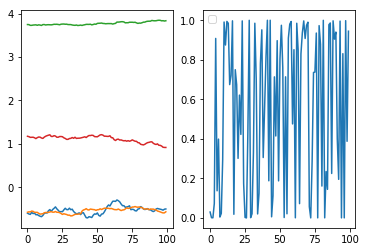

In [4]:
plt.figure()
plt.subplot(121)
plt.plot(w1, label='w1')
plt.plot(w2, label='w2')
plt.plot(w3, label='w3')
plt.plot(w4, label='w4')
plt.subplot(122)
plt.plot(prob)
plt.legend()

## Perform the sampling from the posterior

In [5]:
data_inf = dict(N=N,
               y=yvals.astype('int'),
               g1=g1,
               g2=g2, g3=g3, g4=g4)

init_prob = [dict(prob=np.ones(N) * 0.1)] * 4
samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=200, iter=1000, control={'max_treedepth':18}, init=init_prob)

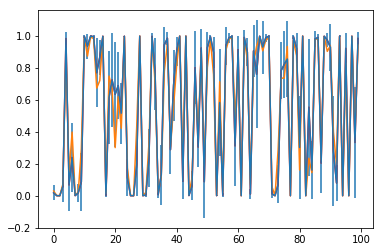

In [6]:
# Get samples of w1 and plot
n1samp = samples_beh_inf['prob']
means = np.mean(n1samp, axis=0)
std = np.std(n1samp, axis=0)
plt.figure(5)

plt.errorbar(np.arange(N), means, 1.96 * std)
plt.plot(means, 'r')
plt.plot(prob)

## Diagnostics

In [7]:
w1samp = samples_beh_inf['w1']
w2samp = samples_beh_inf['w2']
w3samp = samples_beh_inf['w3']
w4samp = samples_beh_inf['w4']
evsamp = samples_beh_inf['evidence']
probsamp = samples_beh_inf['prob']

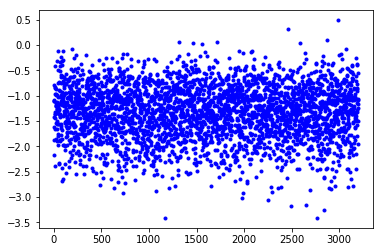

In [8]:
n1samp = samples_beh_inf['w2']
plt.figure()
plt.plot(n1samp[:,7], 'b.');
plt.show()

In [9]:
bebi103.stan.check_all_diagnostics(samples_beh_inf)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 3200 (0.0%) iterations ended with a divergence.
0 of 3200 (0.0%) iterations saturated the maximum tree depth of 18.
E-BFMI indicated no pathological behavior.


0

In [10]:
transformation = lambda x: (x - np.mean(x)) / np.std(x)

bokeh.io.show(bebi103.viz.parcoord_plot(samples_beh_inf, 
                                        transformation=transformation, 
                                        pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                       divergence_alpha=0.1, 
                                        divergence_line_width=0.5))

In [11]:
bokeh.io.show(bebi103.viz.trace_plot(samples_beh_inf, 
                                     pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'], 
                                     inc_warmup=True))

In [12]:
bokeh.io.show(bebi103.viz.corner(samples_beh_inf, 
                                 pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                 labels=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]']))